In [1]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [3]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_face_features):
    super(Emotic,self).__init__()
    self.num_face_features = num_face_features
    self.fc1 = nn.Linear((self.num_face_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_face):
    face_features = x_face.view(-1, self.num_face_features)
    fuse_features = torch.cat((face_features,), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [4]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_face, y_cat, y_cont, transform, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])           # Normalizing the face image with face mean and face std

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.face_norm(self.transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [5]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [6]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''

#Face data
train_face =  np.stack((np.load(os.path.join(data_src,'pre','train_face_arr.npy')),) * 3, axis=-1)
val_face = np.stack((np.load(os.path.join(data_src,'pre','val_face_arr.npy')),) * 3, axis=-1)
test_face = np.stack((np.load(os.path.join(data_src,'pre','test_face_arr.npy')),) * 3, axis=-1)


train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'body', train_face.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'body', val_face.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'body', test_face.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  body (23266, 48, 48, 3) cat  (23266, 26) cont (23266, 3)
val  body (3315, 48, 48, 3) cat  (3315, 26) cont (3315, 3)
test  body (7203, 48, 48, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [7]:
batch_size = 26

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

face_norm = [face_mean, face_std]


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_face, train_cat, train_cont, \
                                  train_transform, face_norm)
val_dataset = Emotic_PreDataset(val_face, val_cat, val_cont, \
                                test_transform, face_norm)
test_dataset = Emotic_PreDataset(test_face, test_cat, test_cont, \
                                 test_transform, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE EMOTIC MODEL

# Face Recognition FER2013

In [8]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [9]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [10]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [11]:
model_face = load_trained_model(face_model_path)

In [12]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [13]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [14]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [15]:
model_face_new = Face_Emotion_CNN_new()

In [16]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

# Face Recognition FER2013 Kaggle

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [ ]:
model_face = Net(1.0)

In [ ]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [ ]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [ ]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [ ]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

# VI. Prepare Model + Optimizer

In [18]:
model_face = model_face_new
emotic_model = Emotic(256)

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_face.parameters():
  param.requires_grad = False


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

## FER-2013

In [20]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [21]:
def test_data(models, device, data_loader, num_images):
    model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_face.to(device)
        emotic_model.to(device)
        model_face.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_face, labels_cat, labels_cont in iter(data_loader):
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [22]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_face.to(device)

    emotic_model.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_face, labels_cat, labels_cont in iter(train_loader):
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_face, labels_cat, labels_cont in iter(val_loader):
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


## FER-2013 Kaggle

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [ ]:
def test_data(models, device, data_loader, num_images):
    model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_face.to(device)
        emotic_model.to(device)
        model_face.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_face, labels_cat, labels_cont in iter(data_loader):
            images_face = images_face.to(device)

            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_face.to(device)

    emotic_model.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_face, labels_cat, labels_cont in iter(train_loader):
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_face, labels_cat, labels_cont in iter(val_loader):
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 498738.3159
vad [1.7682241 2.2131186 2.092527 ] (3,) 2.0246232
epoch = 0 training MAE = 2.0246
epoch = 0 validation loss = 13344.0107
vad [0.9323928 1.1447004 0.7917202] (3,) 0.9562711
epoch = 0 val MAE= 0.9563
saving model at epoch e = 0
epoch = 1 training loss = 256355.7602
vad [1.2019106 1.8346598 1.600368 ] (3,) 1.5456462
epoch = 1 training MAE = 1.5456
epoch = 1 validation loss = 12060.4090
vad [0.7464103 1.1516483 0.7950086] (3,) 0.8976891
epoch = 1 val MAE= 0.8977
saving model at epoch e = 1
epoch = 2 training loss = 241533.5445
vad [1.1318942 1.8143125 1.5375497] (3,) 1.4945854
epoch = 2 training MAE = 1.4946
epoch = 2 validation loss = 9897.6857
vad [0.77598596 1.0429174  0.74937856] (3,) 0.85609394
epoch = 2 val MAE= 0.8561
saving model at epoch e = 2
epoch = 3 training loss = 234666.1889
vad [1.1121569 1.804135  1.5074023] (3,) 1.4745647
epoch = 3 training MAE = 1.4746
epoch = 3 validation loss = 10777.4915
vad [0.7672262 1.0492839 0.8429075] (3,) 0

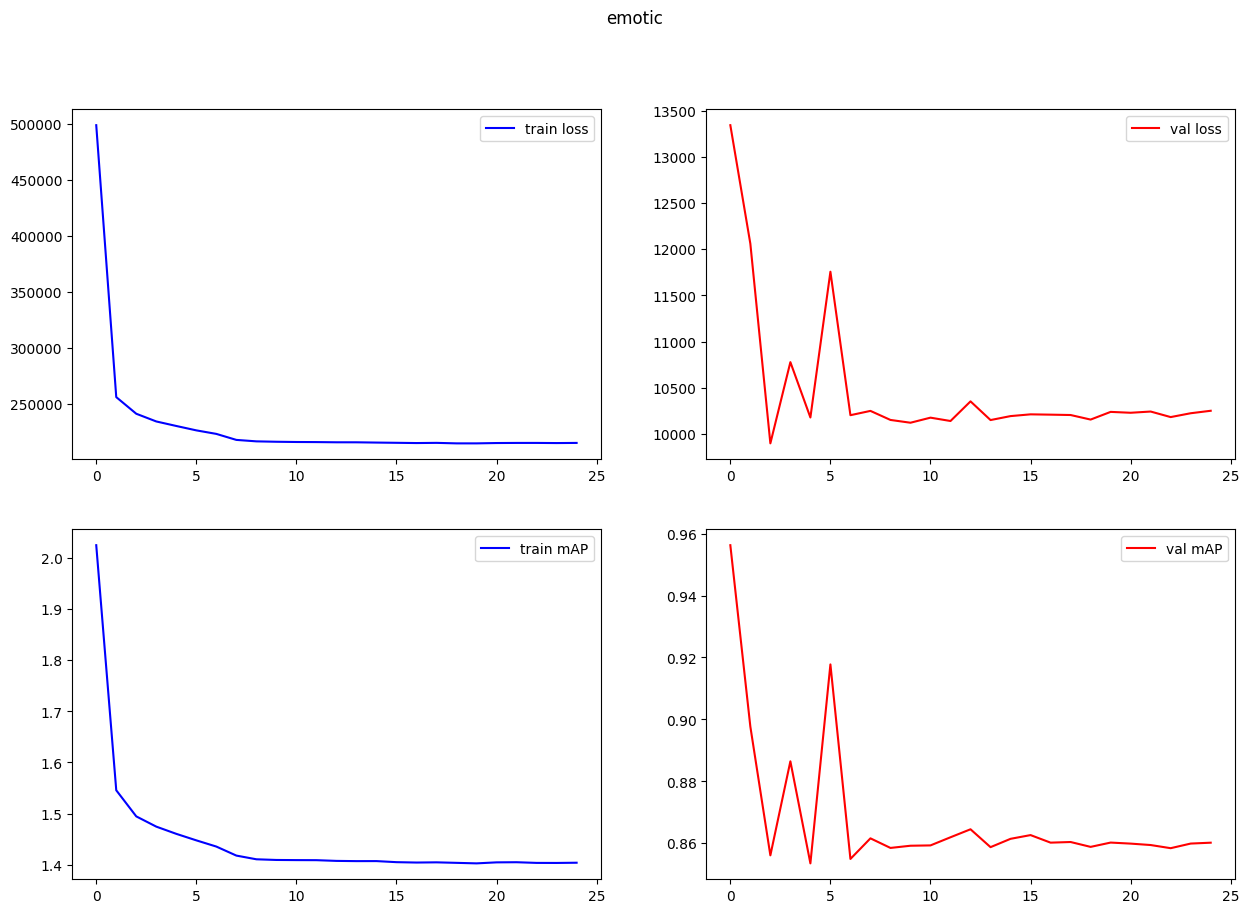

In [23]:
train_emotic(25, './models', opt, scheduler, [model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [24]:
model_path = './models'
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
test_vad = test_data([model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.8897839 1.2534208 1.0073781] (3,) 1.0501943
1.0501943
testing MAE=1.0502


# **Train 2**

---



# Face Recognition FER2013 Kaggle

In [27]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)
         )

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

In [28]:
model_face = Net(1.0)

In [29]:
model_face.load_state_dict(torch.load("/content/drive/MyDrive/VA-prediction/models/FER_2013_Kaggle.pth", map_location=lambda storage, loc: storage), strict=False)

<All keys matched successfully>

In [30]:
print(summary(model_face, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

In [31]:
model_face_new = nn.Sequential(*(list(model_face.children())[:-1]))

In [32]:
print(summary(model_face_new, (3, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             864
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 48, 48]          18,432
              ReLU-5           [-1, 64, 48, 48]               0
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         MaxPool2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]          73,728
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
           Conv2d-11          [-1, 256, 24, 24]         294,912
             ReLU-12          [-1, 256, 24, 24]               0
      BatchNorm2d-13          [-1, 256, 24, 24]             512
           Conv2d-14          [-1, 512,

# VI. Prepare Model + Optimizer

In [33]:
model_face = model_face_new
emotic_model = Emotic(256)

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_face.parameters():
  param.requires_grad = False


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


## FER-2013 Kaggle

In [35]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [36]:
def test_data(models, device, data_loader, num_images):
    model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_face.to(device)
        emotic_model.to(device)
        model_face.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_face, labels_cat, labels_cont in iter(data_loader):
            images_face = images_face.to(device)

            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [37]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_face.to(device)

    emotic_model.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_face, labels_cat, labels_cont in iter(train_loader):
      images_face = images_face.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_face, labels_cat, labels_cont in iter(val_loader):
        images_face = images_face.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 565172.1034
vad [1.9264431 2.2562556 2.2412796] (3,) 2.1413262
epoch = 0 training MAE = 2.1413
epoch = 0 validation loss = 19828.6882
vad [1.0814233 1.2404388 1.1098902] (3,) 1.1439174
epoch = 0 val MAE= 1.1439
saving model at epoch e = 0
epoch = 1 training loss = 274754.0327
vad [1.2827812 1.8549967 1.6718335] (3,) 1.6032038
epoch = 1 training MAE = 1.6032
epoch = 1 validation loss = 13529.5662
vad [0.9171022  1.1342906  0.86684644] (3,) 0.9727464
epoch = 1 val MAE= 0.9727
saving model at epoch e = 1
epoch = 2 training loss = 250407.4696
vad [1.1804829 1.8202163 1.577375 ] (3,) 1.5260247
epoch = 2 training MAE = 1.5260
epoch = 2 validation loss = 13722.9934
vad [0.8505198 1.0616182 1.05068  ] (3,) 0.98760605
epoch = 2 val MAE= 0.9876
epoch = 3 training loss = 240250.8258
vad [1.1375985 1.8085657 1.537156 ] (3,) 1.4944401
epoch = 3 training MAE = 1.4944
epoch = 3 validation loss = 11131.7052
vad [0.7939044  1.0641549  0.82069534] (3,) 0.89291817
epoch = 3 val 

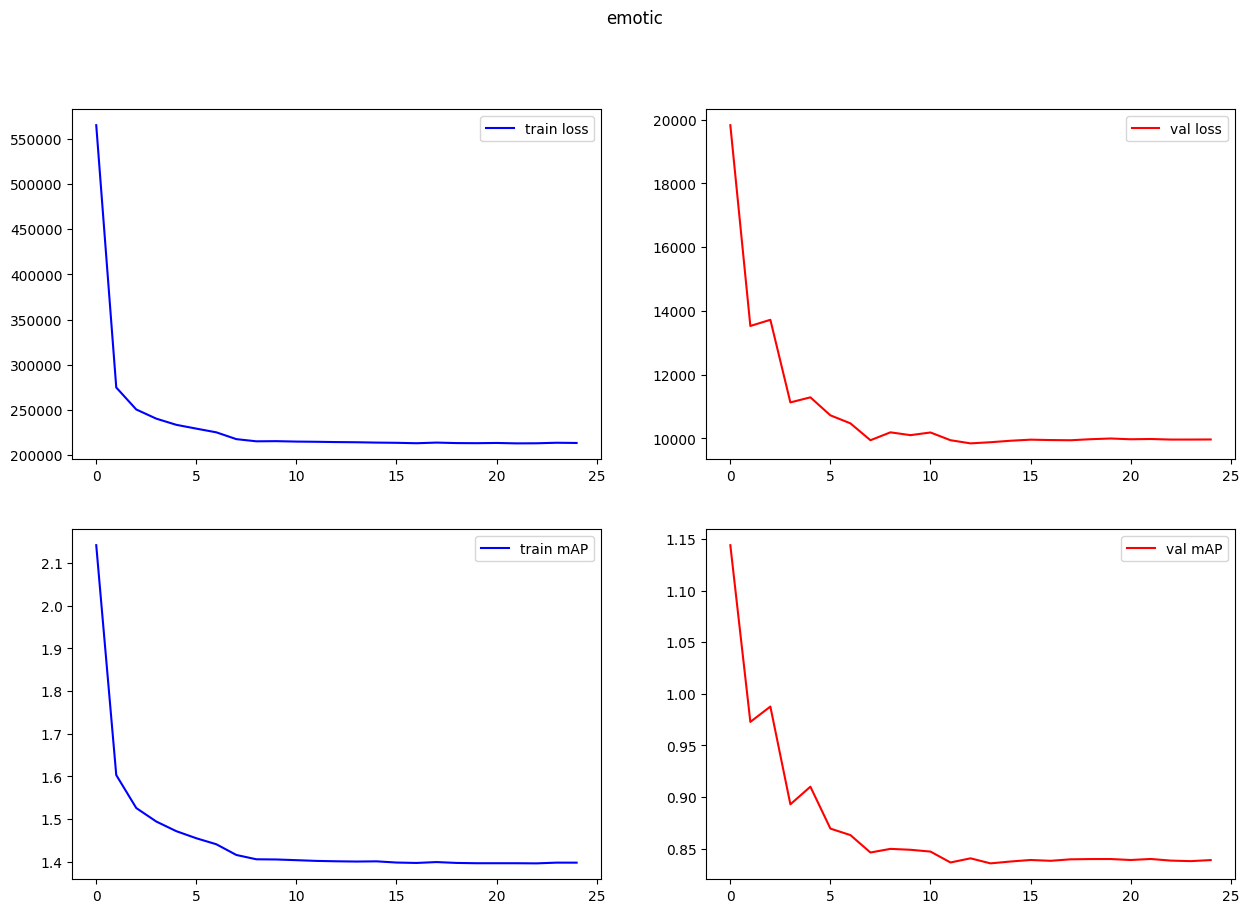

In [38]:
train_emotic(25, './models', opt, scheduler, [model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [39]:
model_path = './models'
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
test_vad = test_data([model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.86793673 1.2202189  0.9808078 ] (3,) 1.0229878
1.0229878
testing MAE=1.0230
